In [1]:
import os
import re
import glob
from datetime import datetime
import sys
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC, Heuristic
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 1. 15 runs

- SimpleLSTM with seeds from 42 to 56
- On OC-3C and OC-3C+
- 90k train, 9k test
- 512 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_42   |     OC-3C    SLSTM_43   |     OC-3C    SLSTM_44   |     OC-3C    SLSTM_45   |     OC-3C    SLSTM_46   |     OC-3C    SLSTM_47   |     OC-3C    SLSTM_48   |     OC-3C    SLSTM_49   |     OC-3C    SLSTM_50   |     OC-3C    SLSTM_51   |     OC-3C    SLSTM_52   |     OC-3C    SLSTM_53   |     OC-3C    SLSTM_54   |     OC-3C    SLSTM_55   |     OC-3C    SLSTM_56   |     OC-3C+    SLSTM_42   |     OC-3C+    SLSTM_43   |     OC-3C+    SLSTM_44   |     OC-3C+    SLSTM_45   |     OC-3C+    SLSTM_46   |     OC-3C+    SLSTM_47   |     OC-3C+    SLSTM_48   |     OC-3C+    SLSTM_49   |     OC-3C+    SLSTM_50   |     OC-3C+    SLSTM_51   |     OC-3C+    SLSTM_52   |     OC-3C+    SLSTM_53   |     OC-3C+    SLSTM_54   |     OC-3C+    SLSTM_55   |     OC-3C+    SLSTM_56   |
|---:|:-----------------------------|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|
|  0 | prec                         |                 0.36441 |                 0.35397 |                 0.38462 |                 0.36813 |                 0.37811 |                 0.37419 |                 0.38523 |                 0.34052 |                 0.3722  |                 0.39108 |                 0.35703 |                 0.38181 |                 0.36864 |                 0.34628 |                 0.37142 |                  0.22822 |                  0.32555 |                  0.36945 |                  0.36879 |                  0.31527 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  1 | rec                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  2 | f1                           |                 0.29667 |                 0.24276 |                 0.29404 |                 0.31864 |                 0.3297  |                 0.31781 |                 0.2985  |                 0.26826 |                 0.2745  |                 0.29808 |                 0.28126 |                 0.29798 |                 0.31248 |                 0.28542 |                 0.30624 |                  0.19255 |                  0.2956  |                  0.29925 |                  0.28082 |                  0.19564 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  3 | acc                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  4 | mcc                          |                 0.07882 |                 0.06828 |                 0.10221 |                 0.08302 |                 0.09732 |                 0.09366 |                 0.094   |                 0.06191 |                 0.08404 |                 0.10601 |                 0.07855 |                 0.09329 |                 0.08554 |                 0.06459 |                 0.08684 |                  0.03069 |                 -0.00037 |                  0.08678 |                  0.08774 |                  0.02772 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |


**Outcome**: Execution became very slow after a few iterations. Had to stop after 20 out of 30. Nevertheless OC-3C+ appears to be worse. The histories show that a the accuracy is not changing at all (especially on OC-3+) -> lower batch size / higher learning rate?

**Winner**: OC-3C

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-15-runs.csv")

## 2. 5 runs (bs=64)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 60k train, 6k test
- 64 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b64_42   |     OC-3C    SLSTM_b64_43   |     OC-3C    SLSTM_b64_44   |     OC-3C    SLSTM_b64_45   |     OC-3C    SLSTM_b64_46   |     OC-3C+    SLSTM_b64_42   |     OC-3C+    SLSTM_b64_43   |     OC-3C+    SLSTM_b64_44   |     OC-3C+    SLSTM_b64_45   |     OC-3C+    SLSTM_b64_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.11111 |                     0.32211 |                     0.22711 |                     0.31561 |                     0.23353 |                      0.11111 |                      0.11111 |                      0.36631 |                            0 |                            0 |
|  1 | rec                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  2 | f1                           |                     0.16667 |                     0.30668 |                     0.1786  |                     0.21627 |                     0.18374 |                      0.16667 |                      0.16667 |                      0.31404 |                            0 |                            0 |
|  3 | acc                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  4 | mcc                          |                     0       |                     0.01561 |                     0.02991 |                     0.04257 |                     0.03177 |                      0       |                      0       |                      0.08696 |    

**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs64.csv")

## 3. 5 runs (bs=16)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 45k train, 4.5k test
- 16 batch size
- 100 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b16_42   |     OC-3C    SLSTM_b16_43   |     OC-3C    SLSTM_b16_44   |     OC-3C    SLSTM_b16_45   |     OC-3C    SLSTM_b16_46   |     OC-3C+    SLSTM_b16_42   |     OC-3C+    SLSTM_b16_43   |     OC-3C+    SLSTM_b16_44   |     OC-3C+    SLSTM_b16_45   |     OC-3C+    SLSTM_b16_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.25112 |                     0.11111 |                     0.11111 |                     0.11111 |                     0.11111 |                      0.11111 |                      0.11111 |                      0.2391  |                      0.11111 |                      0.11111 |
|  1 | rec                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  2 | f1                           |                     0.18983 |                     0.16667 |                     0.16667 |                     0.16667 |                     0.16667 |                      0.16667 |                      0.16667 |                      0.1848  |                      0.16667 |                      0.16667 |
|  3 | acc                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  4 | mcc                          |                     0.03562 |                     0       |                     0       |                     0       |                     0       |                      0       |                      0       |                      0.03018 |                      0       |                      0       |


**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs16.csv")

Failed settings:
- n_units=[128, 128], lstm_dropout=0.4, lr=0.001, bs=16, epoch=20, 45k
- n_units=[256, 256], bs=64, epoch=10, 150k

# 4. 2 runs on new test data

- SimpleLSTM with seeds from 42 to 43, Heuristics, MLP, SVC
- On OCM-3C
- 240k train, 48k test (not balanced)
- 64 batch size
- 100 epochs
- 64 & 64 units
- 0.001 learning rate

|  -   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    Heuristic_all   |     OCM-3C    Heuristic_l1   |     OCM-3C    Heuristic_l3   |     OCM-3C    MLP   |     OCM-3C    SVC   |
|:-----|-------------------------:|-------------------------:|-----------------------------:|----------------------------:|----------------------------:|--------------------:|--------------------:|
| prec |                  0.50297 |                  0.50447 |                      0.48738 |                     0.49216 |                     0.47567 |             0.50176 |             0.46663 |
| rec  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| f1   |                  0.52308 |                  0.52249 |                      0.49012 |                     0.49198 |                     0.50026 |             0.4658  |             0.47941 |
| acc  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| mcc  |                  0.08959 |                  0.09124 |                      0.03097 |                     0.06258 |                     0.03274 |             0.06744 |             0.00323 |

# 5. Final AI approaches

- SimpleLSTM with seeds from 42 to 46, MLP
- On OCM-3C and OCMvOC-3C (aborted during the 2. dataset)
- 300k train, 60k test (not balanced)
- 128 batch size
- 100 epochs
- 128 & 128 units
- 0.001 learning rate


| -  |   datasets    predictors     |     OCM-3C    MLP   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    SLSTM_s44   |     OCM-3C    SLSTM_s45   |     OCM-3C    SLSTM_s46   |     OCMvOC-3C    MLP   |     OCMvOC-3C    SLSTM_s42   |     OCMvOC-3C    SLSTM_s43   |     OCMvOC-3C    SLSTM_s44   |     OCMvOC-3C    SLSTM_s45   |     OCMvOC-3C    SLSTM_s46   |
|---:|:-----------------------------|--------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|-----------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |             0.5062  |                   0.5017  |                   0.50005 |                   0.49935 |                   0.50105 |                   0.5021  |                0.37399 |                      0.44839 |                      0.47712 |                            0 |                            0 |                            0 |
|  1 | rec                          |             0.38905 |                   0.55497 |                   0.55277 |                   0.55835 |                   0.55803 |                   0.56537 |                0.21137 |                      0.29092 |                      0.33253 |                            0 |                            0 |                            0 |
|  2 | f1                           |             0.41822 |                   0.52137 |                   0.51972 |                   0.51997 |                   0.52126 |                   0.52347 |                0.18204 |                      0.3115  |                      0.35872 |                            0 |                            0 |                            0 |
|  3 | acc                          |             0.38905 |                   0.55497 |                   0.55277 |                   0.55835 |                   0.55803 |                   0.56537 |                0.21137 |                      0.29092 |                      0.33253 |                            0 |                            0 |                            0 |
|  4 | mcc                          |             0.05772 |                   0.08206 |                   0.07897 |                   0.07759 |                   0.08078 |                   0.08343 |               -0.03582 |                     -0.01074 |                      0.02517 |                            0 |                            0 |                            0 |

[comment]: <> (print_metrics_as_md "../reports/custom/ml-baselines-2.csv")

# 6. All Baselines

| -  |   datasets    predictors     |     OCMvOC-3C    Heuristic_all   |     OCMvOC-3C    Heuristic_l1   |     OCMvOC-3C    Heuristic_l3   |     OCMvOC-3C    Heuristic_v_l1   |     OCMvOC-3C    MLP   |     OCMvOC-3C    SLSTM   |     OCMvOC-3C    SVC   |
|---:|:-----------------------------|---------------------------------:|--------------------------------:|--------------------------------:|----------------------------------:|-----------------------:|-------------------------:|-----------------------:|
|  0 | prec                         |                          0.48365 |                         0.49756 |                         0.48274 |                           0.47925 |                0.40024 |                  0.48386 |                0.52198 |
|  1 | rec                          |                          0.61467 |                         0.49363 |                         0.57635 |                           0.53523 |                0.22668 |                  0.60472 |                0.62097 |
|  2 | f1                           |                          0.49376 |                         0.49556 |                         0.50701 |                           0.50027 |                0.2169  |                  0.4935  |                0.48285 |
|  3 | acc                          |                          0.61467 |                         0.49363 |                         0.57635 |                           0.53523 |                0.22668 |                  0.60472 |                0.62097 |
|  4 | mcc                          |                          0.03026 |                         0.06588 |                         0.0397  |                           0.04045 |               -0.03705 |                  0.02065 |                0.00765 |

In [2]:
datasets = [
    # NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', epsilon=0.0055, companies=['GOOGL', 'GOOG', 'AXP', 'GM', 'WMT', 'AMZN', 'APC', 'MSFT']),
    # NyseStocksDataset('OCM-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement']),
    NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close']),
    # NyseStocksDataset('OC-3C+', file_path='../data/nyse/prices-split-adjusted.csv'),
]
[ds.load() for ds in datasets];


time: 13.9 s


2019-01-02 16:18:39 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2019-01-02 16:18:41 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2019-01-02 16:18:41 [INFO] src.preparation: Training range: 2010-01-04 00:00:00 to 2014-06-09 00:00:00
2019-01-02 16:18:41 [INFO] src.preparation: Test Labels --> -1.0: 10040; 0.0: 37460; 1.0: 12500
2019-01-02 16:18:42 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2019-01-02 16:18:42 [INFO] src.preparation: Done preparing data
2019-01-02 16:18:42 [INFO] src.evaluation.evaluator: ---------- SLSTM | OCMvOC-3C ----------


2019-01-02 19:22:42 [INFO] src.evaluation.evaluator: Store evaluator results at C:\Users\Thomas\HPI\MA\reports\evaluators\all-baselines-slstm-2019-01-02-192242.pkl
2019-01-02 19:22:43 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-all-baselines-slstm\histories\history--SLSTM-on-OCMvOC-3C-2019-01-02-192242.png


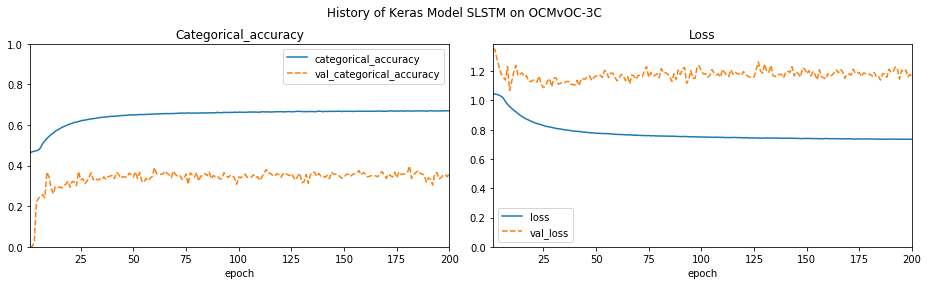

time: 3h 4min 4s


In [21]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    # seeds = range(42, 47)
    return [
        # Heuristic('_l1', n_features, n_timestamps, Heuristic.last_movement, movement_feat=-3),
        # Heuristic('_all', n_features, n_timestamps, Heuristic.mean_movement, movement_feat=-3),
        # Heuristic('_l3', n_features, n_timestamps, Heuristic.last_three_movements, movement_feat=-3),
        # Heuristic('_v_l1', n_features, n_timestamps, Heuristic.last_vix_movement, vix_feats=[-2, -1]),
        # MLPClassifier(),
        # SVC(),
        SimpleLSTM(n_timestamps=n_timestamps, n_features=n_features-2, n_classes=n_classes, ignore_features=[-2, -1], seed=42),
        # *[SimpleLSTM(f'_s{s}', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s) for s in seeds]
    ]
evaluator = Evaluator('all-baselines-slstm', datasets, get_predictors, '../reports', seed=42, store=True,
                      n_train_samples=300000, n_test_samples=60000, downsample=True)
metrics = evaluator()

In [22]:
# evaluator._metrics
metrics

datasets,OCMvOC-3C
predictors,SLSTM
prec,0.45982
rec,0.30885
f1,0.33586
acc,0.30885
mcc,-0.00704


time: 265 ms


In [23]:
print_metrics_as_md("../reports/custom/all-baselines-slstm.csv")

| -  |   datasets    predictors     |     OCMvOC-3C    SLSTM   |
|---:|:-----------------------------|-------------------------:|
|  0 | prec                         |                  0.45982 |
|  1 | rec                          |                  0.30885 |
|  2 | f1                           |                  0.33586 |
|  3 | acc                          |                  0.30885 |
|  4 | mcc                          |                 -0.00704 |
time: 278 ms


In [ ]:
# evaluator._metrics.to_csv(os.path.join(evaluator.output_dir, f'custom/{evaluator.name}.csv'))
# evaluator.plot_histories()